In [63]:
import json
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [64]:
def get_distribution(fnc_name, params, dim):
    # define a "complex"-custom distribution
    def custom(n):
        X_1 = np.random.normal(-2,0.3,size=(n,dim))
        X_2 = np.random.normal(4,2,size=(n,dim))
        X_3 = np.random.uniform(-6,4,size=(n,dim))
        X = np.concatenate([X_1,X_2,X_3])
        indices = np.random.randint(0,3*n,size=n)
        return X[indices]
    # get standard numpy distributions
    def P(n):
        if fnc_name == "multivariate_normal":
            return np.random.multivariate_normal(**params, size=n)
        else:
            fnc = getattr(np.random, fnc_name)
            return fnc(**params,size=(n,dim))

    if fnc_name == "custom":
        return custom
    else:
        return P


## Laden eines Samples

In [65]:
sample = "evaluation/disc-large-custom-m1000/1"

In [66]:
with open("../"+sample+"/setup.json") as fp: setup = json.load(fp)

## Modelle

In [67]:
D = tf.keras.models.model_from_json(setup["D"])
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 31,501
Trainable params: 31,501
Non-trainable params: 0
_________________________________________________________________


In [68]:
G = tf.keras.models.model_from_json(setup["G"])
G.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 125)               250       
_________________________________________________________________
dense_11 (Dense)             (None, 125)               15750     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 126       
Total params: 16,126
Trainable params: 16,126
Non-trainable params: 0
_________________________________________________________________


## Verteilungen

In [69]:
def plot_distribution(samples, bins):
    plt.cla();plt.clf()
    plt.figure(figsize=(10,5))
    print(samples.shape)
    plt.hist(samples, bins=BINS)
    plt.show()

In [70]:
N = 100000
BINS = int(np.sqrt(N))

(100000, 1)


<Figure size 432x288 with 0 Axes>

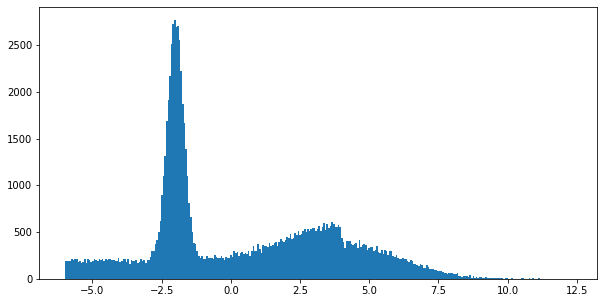

In [71]:
P_X = get_distribution(**setup["P_X"])
plot_distribution(P_X(N), BINS)

(100000, 10)


<Figure size 432x288 with 0 Axes>

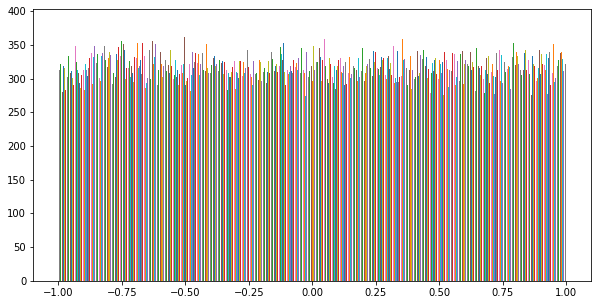

In [72]:
P_U = get_distribution(**setup["P_U"])
plot_distribution(P_U(N), BINS)

## Training

In [73]:
with open("../"+sample+"/training.json") as fp: training = json.load(fp)

### Risiken

In [74]:
def plot_risks(R_d, R_g):
    plt.cla();plt.clf()
    plt.figure(figsize=(20,10))
    # R(d)
    plt.subplot(1,2,1)
    plt.title("Empirisches Risiko des Diskriminators")
    plt.plot(R_d)
    # R(g)
    plt.subplot(1,2,2)
    plt.title("Empirisches Risiko des Generators")
    plt.plot(R_g)
    # Display
    plt.show()

<Figure size 432x288 with 0 Axes>

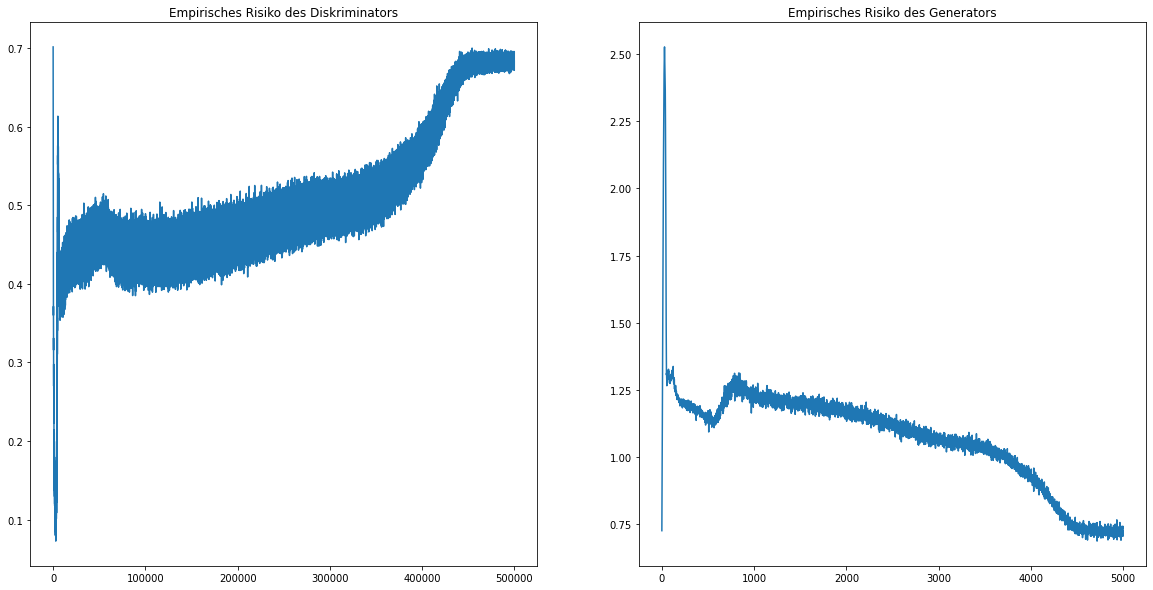

In [75]:
plot_risks(training["R_d"], training["R_g"])

### Trainingsbeispiele

In [76]:
training_samples = np.load("../"+sample+"/training_samples.npy")
training_samples.shape

(5000, 500, 1)

In [77]:
def plot_training_samples(samples):
    plt.cla();plt.clf()
    plt.figure(figsize=(25,25))
    BINS = int(np.sqrt(samples.shape[1]))*2
    for plt_nr, sample_idx in enumerate(range(0,samples.shape[0],300)):
        plt.title("Epoche Nr. {}".format(sample_idx+1))
        plt.subplot(5,5,plt_nr+1)
        plt.hist(samples[sample_idx], bins=BINS)
    plt.show()

<Figure size 432x288 with 0 Axes>

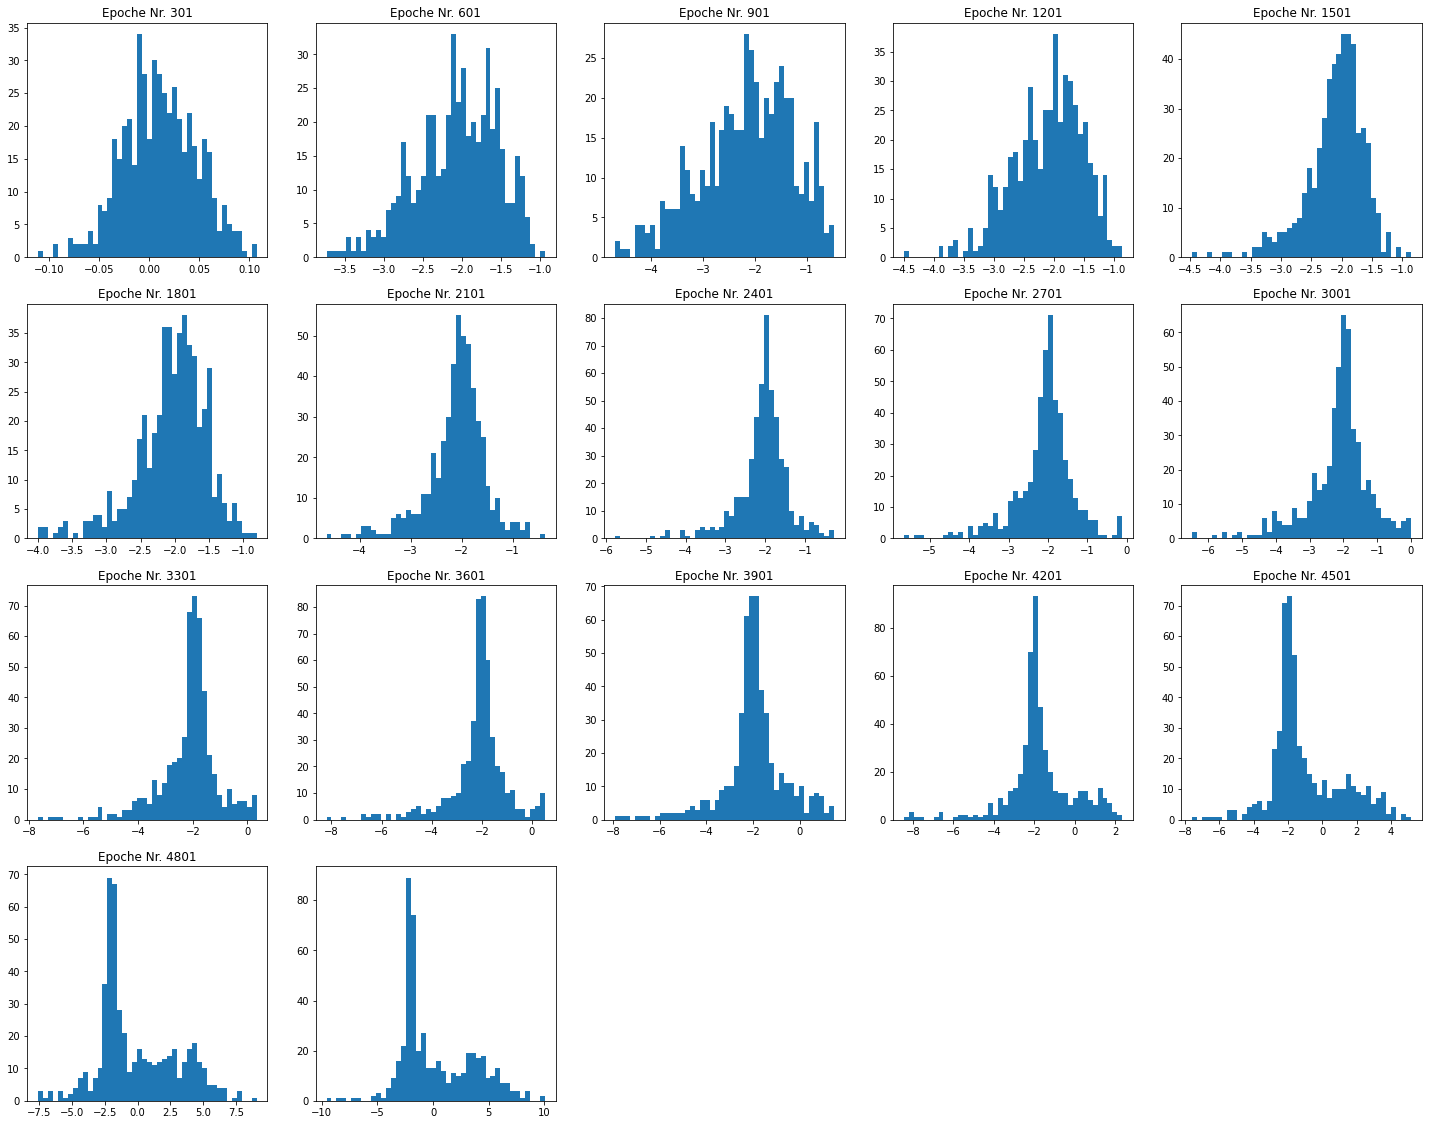

In [78]:
plot_training_samples(training_samples)

### Diskriminator-Metriken

In [79]:
y_true_and_pred = np.load("../"+sample+"/y_true_and_pred.npy")
y_true_and_pred.shape

(250000, 1000, 1, 2)

In [80]:
y_true = y_true_and_pred[:,:,0,0]
y_pred = y_true_and_pred[:,:,0,1]
y_pred_binary = y_pred.round()
y_true.shape, y_pred_binary.shape

((250000, 1000), (250000, 1000))

In [81]:
def plot_metrics(acc_chart, prc_chart, rec_chart, spc_chart):
    plt.cla();plt.clf()
    plt.figure(figsize=(20,20))
    # Acc
    plt.subplot(2,2,1)
    plt.title("Accuracy [ (tp+tn)/n ] des Diskriminators")
    plt.plot(acc_chart)
    # Prc
    plt.subplot(2,2,2)
    plt.title("Precision [ tp/(tp+fp) ] des Diskriminators")
    plt.plot(prc_chart)
    # Rec
    plt.subplot(2,2,3)
    plt.title("Recall [ tp/(tp+fn) ] des Diskriminators")
    plt.plot(rec_chart)
    # Acc
    plt.subplot(2,2,4)
    plt.title("Specificity [ tn/(tn+fp) ] des Diskriminators")
    plt.plot(spc_chart)
    # Display
    plt.show()

#### Metriken Berechnen

In [82]:
N = y_true.shape[1]
tp = np.sum(np.logical_and(y_true==1, y_pred_binary==1), axis=-1)
tn = np.sum(np.logical_and(y_true==0, y_pred_binary==0), axis=-1)
fp = np.sum(np.logical_and(y_true==0, y_pred_binary==1), axis=-1)
fn = np.sum(np.logical_and(y_true==1, y_pred_binary==0), axis=-1)
N, tp, tn, fp, fn

(1000,
 array([275, 254, 259, ..., 315, 288, 268]),
 array([294, 294, 317, ..., 232, 271, 279]),
 array([202, 208, 186, ..., 272, 245, 238]),
 array([229, 244, 238, ..., 181, 196, 215]))

In [83]:
acc_chart = (tp+tn)/N
prc_chart = tp/(tp+fp)
rec_chart = tp/(tp+fn)
spc_chart = tn/(tn+fp)

acc_chart.shape

(250000,)

#### Metriken Anzeigen

<Figure size 432x288 with 0 Axes>

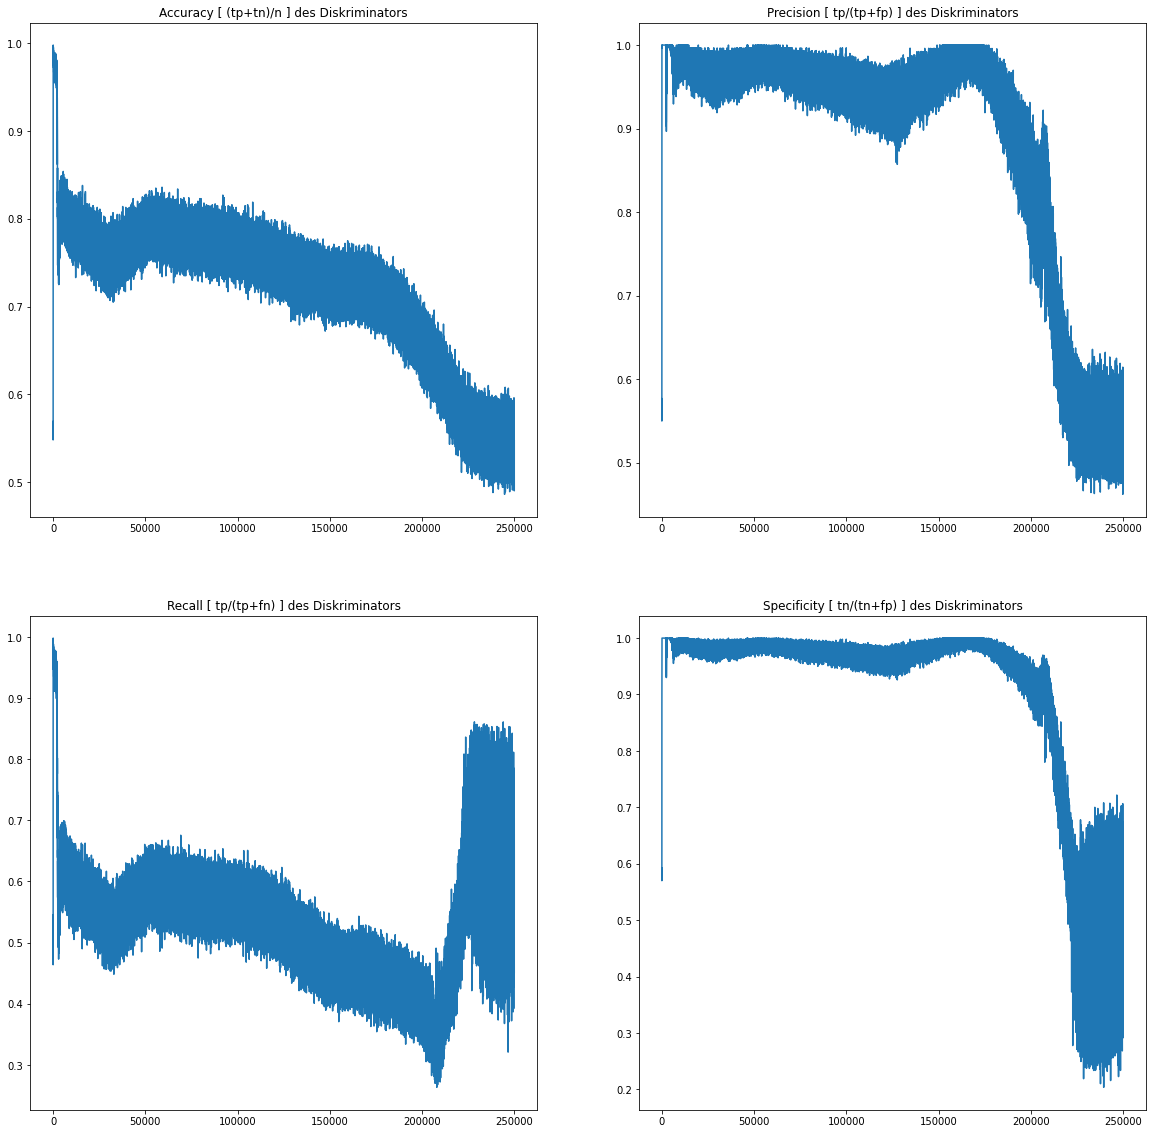

In [84]:
plot_metrics(acc_chart, prc_chart, rec_chart, spc_chart)

#### Geglättete Metriken anzeigen

In [85]:
n_ma = 1000
plot_metrics(
    np.convolve(acc_chart, np.ones(n_ma)/n_ma, mode='valid'),
    np.convolve(prc_chart, np.ones(n_ma)/n_ma, mode='valid'),
    np.convolve(rec_chart, np.ones(n_ma)/n_ma, mode='valid'),
    np.convolve(spc_chart, np.ones(n_ma)/n_ma, mode='valid'),
)

<Figure size 432x288 with 0 Axes>

## Nach dem Training

### Trainierten Generator laden

In [86]:
G_trained = tf.keras.models.load_model("../"+sample+"/generator")
G_trained.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 31,501
Trainable params: 31,501
Non-trainable params: 0
_________________________________________________________________


### Histogram von Beispielen

In [87]:
def plot_distributions(samples_true, samples_generated):
    plt.cla();plt.clf()
    plt.figure(figsize=(10,5))
    plt.hist(samples_true, bins=int(np.sqrt(samples_true.shape[0])), label="Verteilung der Daten", density=True)
    plt.hist(samples_generated, bins=int(np.sqrt(samples_generated.shape[0])), label="Generierte Verteilung", alpha=0.7, density=True)
    plt.legend()
    plt.show()

In [88]:
N_MC = 100000

In [89]:
X_mc = P_X(N_MC)

In [90]:
X_gen = G_trained.predict(P_U(N_MC))

<Figure size 432x288 with 0 Axes>

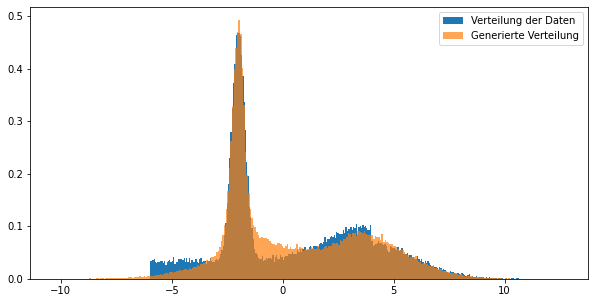

In [91]:
plot_distributions(X_mc, X_gen)

### Die Verteilungsfunktionen

In [92]:
def plot_cdf(samples_true, samples_generated):
    N_true, N_generated = samples_true.shape[0], samples_generated.shape[0]
    # get the lowest value for both sample sets
    min_val = min(
        np.min(samples_true),
        np.min(samples_generated)
    )
    # get the ighest value for both sample sets
    max_val = max(
        np.max(samples_true),
        np.max(samples_generated)
    )
    # get a "grid" between those 2
    grid = np.arange(min_val, max_val, (max_val-min_val)/1000)
    # calculate the cdf
    cdf_true = [samples_true[samples_true < x].shape[0]/N_true for x in grid]
    cdf_generated = [samples_generated[samples_generated < x].shape[0]/N_true for x in grid]
    # plotting
    plt.cla();plt.clf()
    plt.figure(figsize=(10,5))
    plt.plot(cdf_true, label="Empirische Verteilungsfunktion der Daten")
    plt.plot(cdf_generated, label="Empirische Verteilungsfunktion der generierten Daten")
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

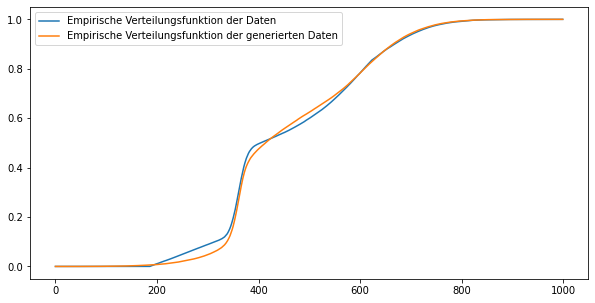

In [93]:
plot_cdf(X_mc, X_gen)